# Project Barry

As far as I can remember, I've been a huge pokemon fan. whether it was playing the games growing up, watching the shows, and many playing in an imaginary pokemon world ~even as an adult~ as a kid. When I reached college, I began to get into competitive Pokemon, which for those of you who don't know, is a thing. After spending many hours and tears on studying Statistics and Machine Learning in college, I have alwayhs wondered what it would take to create a proper pokemon battling AI (more on this later). There are a lot of things that go into competitive pokemon, but for the sake of this project, I won't get into too much detail here about the competitive scene, instead all you need to know is that I'll be programming a bot that is able to battle under the Smogon Generation 9 OverUsed tier. This is a 6v6 pokemon format that has a few rules attached that you can look up online. I'll explain some of the details for how pokemon battling works below.

## What is a Pokemon Battle?
For those of you who have never touched the franchise besides reading articles about Pokemon Card scalpers, that one summer Pokemon Go blew up, or the only pokemon you know is a Pikachu, this section is for you. A Pokemon battle (under the rules my bot is running under) contains two players who each have 6 pokemon with the goal of reducing the Health of all the opponent's pokemon to 0. Each pokemon has differents typings, stats, and abilities that contribute to what it can do in a battle. Additionally, every pokemon has multiple moves it can learn, and can only use 4 in each battle. During each turn, you have one active Pokemon out, and must choose either one of your 4 moves or to switch into one of your remaining pokemon that still has health. 

If you've never played Pokemon before, you can try battling on Pokemon Showdown, a free online battle simulator, to try it out yourself. Or if you have money to spare, just buy one of the games to play. My explanation above is merely scratching the surface of what Pokemon is, but in the future I will try to write up a better guide to explain everything

## What makes Pokemon Battling an interesting ML Question
Ok for the Machine Learning people, this will be more for you. Pokemon Battling is a fascinating game because while it's a turnbased game, there are so many factors that can go down in a single turn. While you may know what Pokemon your opponent brought, you have no clue what item, ability, or stat spread they may have. This could drastically affect whether you want to switch into a different pokemon or stay in and risk getting caught off guard. As with many games, most pokemon sets are similar or need to be run with other specific sets, which allows pros to deduce what their opponent may have. Even then, the uncertainty of what a Pokemon could have forces players to make "safer" plays.

Another thing to consider is that for every move you do, your opponent does a move at the same time, so you need to predict what they may be doing. This transforms the game from simplying "knowing what the best move is" to needing to play a mental game with your opponent. Top level players understand this and will play mindgames with their opponents such as conditioning them to expect a certain play, or pushing offensive momentum in the game which forces the opponent to make safer plays while on the backfoot.

## What has been looked into before?
Being the highest grossing franchise in the world, there are a couple of projects created by others in attempt to create a Pokemon battling AI. Some noteable ones are Future Sight AI made by The Third Build. This is an amazing project and for the Smogon nerds out there, it managed to hit upper 1500's on the Gen 8 OU Ladder. For the layperson, this means it's better than the average battler but not good enough to hit the competitive level. Another fascinating attempt was Athena2020, which managed to hit top 500 in Gen 7 Random Battles.

This project is my attempt at creating a Pokemon Battling AI. I'll be approaching this using Reinforcement Learning. Unlike the other projects, I will start small by creating a battling AI with a specific scope, and move to generalizing an AI once I feel more comfortable.

In [1]:
import numpy as np
from TrainerMax import MaxDamagePlayer
from gym.spaces import Space, Box
from poke_env.player import Gen9EnvSinglePlayer
from gym.utils.env_checker import check_env
from poke_env.environment.abstract_battle import AbstractBattle
from poke_env.environment.side_condition import STACKABLE_CONDITIONS, SideCondition
from poke_env.player import RandomPlayer
from poke_env.player import background_evaluate_player
from poke_env.player_configuration import PlayerConfiguration

import math
import random
from collections import namedtuple, deque
from itertools import count
import matplotlib.pyplot as plt

#Insert in Pytorch Code here
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

DDQN Model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
# Get number of actions from gym action space


class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 512)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(256, 128)
        self.layer5 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        return self.layer5(x)

# Battle Bot Env
I'm starting by looking at a Double DQN architecture. Most of the code is based on the Poke-Env website.

In [3]:
battle_tester = None

class Barry(Gen9EnvSinglePlayer):

    def capture_replay(self, capture: bool = True):
        self.save_replays = capture
        
    def calc_reward(self, last_battle, current_battle) -> float: #RECREATE
        global battle_tester
        battle_tester = current_battle
        return self.reward_computing_helper(
            current_battle, fainted_value=2.0, hp_value=1.0, victory_value=30.0
        )
    
    def encode_status(self, status):
        if status == None:
            return [0, 0, 0, 0, 0]
        encoded = []
        for s in ("FNT", "BRN", "PSN", "SLP", "TOX"): #PAR and FRZ not included for this bot
            if status.name == s:
                encoded.append(1)
            else:
                encoded.append(0)
        return encoded

    def encode_hazards(self, hazard_dict):
        encoded = [0]
        if hazard_dict.get(SideCondition(16)):
            encoded[0] = 1
        for h in (15, 19):
            if hazard_dict.get(SideCondition(h)) != None:
                encoded.append(hazard_dict.get(SideCondition(h)))
            else:
                encoded.append(0)
        return encoded
    
    def team_preview_embedding(self): 
        battle = []
        #Active Field
        battle += [0]*14
        battle += [0, 0, 0, 0, 0, 100, 1, 0]*6
        battle += battle
        return np.float32(battle) #size 124

    def embed_battle(self, battle: AbstractBattle):
        #global battle_tester Used for Testing
        #battle_tester = battle
        
        if battle._in_team_preview:
            return self.team_preview_embedding()
        
        active_field = []
        # 0:5 - which pokemon is active
        # 6:10 - Modifiers
        # 11:13 - Hazard

        for k in battle.team.keys():
            if battle.team[k].active:
                active_field.append(1)
            else:
                active_field.append(0)
        #active_field[list(battle.team).index("p1: " + battle.active_pokemon.species.capitalize())] = 1
        active_field.append(battle.active_pokemon.boosts.get("atk"))
        active_field.append(battle.active_pokemon.boosts.get("def"))
        active_field.append(battle.active_pokemon.boosts.get("spa"))
        active_field.append(battle.active_pokemon.boosts.get("spd"))
        active_field.append(battle.active_pokemon.boosts.get("spe")) #11
        active_field = active_field + self.encode_hazards(battle.side_conditions) #Len 14

        pokemon_team = [] #np.ones(42)
        # For all 6 Pokemon
        # 0:4 - Status
        # 5 - HP
        # 6 - has_item
        # 7 - Terastralized
        
        for p in list(battle.team):
            poke = battle.team[p]
            poke_info = self.encode_status(poke.status)# Len 5
            poke_info.append(poke.current_hp_fraction*100) # Len 1
            poke_info.append(int(poke.item != "")) # Len 1
            poke_info.append(int(poke.terastallized)) # Len 1
            pokemon_team = pokemon_team + poke_info # Len 48

        opponent_active_field = []
        # 0:5 - which pokemon is active
        # 6:10 - Modifiers
        # 11:13 - Hazard
        for tpo in list(battle._teampreview_opponent_team):
            opponent_active_field.append(int(tpo.species == battle.opponent_active_pokemon.species))
            
        opponent_active_field.append(battle.opponent_active_pokemon.boosts.get("atk"))
        opponent_active_field.append(battle.opponent_active_pokemon.boosts.get("def"))
        opponent_active_field.append(battle.opponent_active_pokemon.boosts.get("spa"))
        opponent_active_field.append(battle.opponent_active_pokemon.boosts.get("spd"))
        opponent_active_field.append(battle.opponent_active_pokemon.boosts.get("spe"))
        opponent_active_field = opponent_active_field + self.encode_hazards(battle.opponent_side_conditions)

        opponent_pokemon_team = []
        # For all 6 Pokemon
        # 0:3 - Status
        # 4 - HP
        # 5 - has_item
        # 6 - Terastralized
        for p in list(battle._teampreview_opponent_team):
            if ("p2: " + p.species.capitalize()) in battle.opponent_team:
                opponent_pokemon = battle.opponent_team["p2: " + p.species.capitalize()]
                op_poke_info = self.encode_status(opponent_pokemon.status)
                op_poke_info.append(opponent_pokemon.current_hp_fraction*100)
                op_poke_info.append(int(opponent_pokemon.item != ""))
                op_poke_info.append(int(opponent_pokemon.terastallized))
            #opponent_pokemon = battle.opponent_team["p2: " + p.species.capitalize()]
            #if opponent_pokemon == None:
            #    op_poke_info = [0, 0, 0, 0, 0, 100, 1, 0]
            else:
                op_poke_info = [0, 0, 0, 0, 0, 100, 1, 0]
                
            opponent_pokemon_team = opponent_pokemon_team + op_poke_info
        # print(len(active_field))
        # print(len(pokemon_team))
        # print(len(opponent_active_field))
        # print(len(opponent_pokemon_team))
        # Final vector
        final_vector = active_field + pokemon_team + opponent_active_field + opponent_pokemon_team
        return np.float32(final_vector)

    def describe_embedding(self) -> Space: #Still need to complete
        low = []
        high = []
        
        #Active Pokemon
        low += [0, 0, 0, 0, 0, 0]
        high += [1, 1, 1, 1, 1, 1]
        
        #Modifier
        low += [0, 0, 0, 0, 0]
        high += [4, 4, 4, 4, 4]

        #Hazards
        low += [0, 0, 0] 
        high += [1, 3, 3] #CHECK SPIKES

        #Each Pokemon
        poke_low = []
        poke_high = []
        #Status
        poke_low += [0, 0, 0, 0, 0]
        poke_high += [1, 1, 1, 1, 1]
        #HP
        poke_low += [0]
        poke_high += [100] 
        #Has_Item
        poke_low += [0]
        poke_high += [1]
        #Terastralized
        poke_low += [0]
        poke_high += [1]
        #Add to embedding
        low += poke_low*6
        high += poke_high*6

        #Repeat for opponent side
        low += low
        high += high
        return Box(
            np.array(low, dtype=np.float32),
            np.array(high, dtype=np.float32),
            dtype=np.float32,
        )

# Teams
NOTE: AS OF THE TIME I'M WRITING THIS VOLCARONA JUST GOT BANNED FROM OU SO I'LL BE LOOKING FOR A DIFFERENT TEAM
For the teams, I'm choosing two sample teams for Gen9 OU. One team can be categorized as "Hyper Offense" (HO) and is characterized by have hard hitting pokemon. HO teams are very frail and a good HO player needs to sacrifice (sack) pokemon to keep up momentum. The other team is known as "Stall", which is characterized by taking its time to slowly destroy the opponent. This style of team typically requires a lot of time and patience to wear down the opponent's pokemon (and mental state) and requires bulky pokemon which can take hits and heal.

HO Team. While HO is difficult to pilot, a strong player knows how to run one well, and it can be extremely oppresive if played right. Requires a lot of skill to be able to pilot correctly.

In [4]:
SUSHO = """
Volcarona @ Heavy-Duty Boots  
Ability: Flame Body  
Tera Type: Water  
EVs: 252 SpA / 4 SpD / 252 Spe  
Timid Nature  
IVs: 0 Atk  
- Quiver Dance  
- Bug Buzz  
- Flamethrower  
- Tera Blast  

Hatterene (F) @ Leftovers  
Ability: Magic Bounce  
Tera Type: Water  
EVs: 252 HP / 200 Def / 56 Spe  
Bold Nature  
IVs: 0 Atk  
- Calm Mind  
- Draining Kiss  
- Psyshock  
- Mystical Fire  

Roaring Moon @ Booster Energy  
Ability: Protosynthesis  
Tera Type: Flying  
EVs: 252 Atk / 4 SpD / 252 Spe  
Jolly Nature  
- Dragon Dance  
- Knock Off  
- Acrobatics  
- Earthquake  

Glimmora @ Focus Sash  
Ability: Toxic Debris  
Tera Type: Ghost  
EVs: 4 Def / 252 SpA / 252 Spe  
Timid Nature  
- Stealth Rock  
- Mortal Spin  
- Earth Power  
- Power Gem  

Kingambit @ Leftovers  
Ability: Supreme Overlord  
Tera Type: Fighting  
EVs: 208 HP / 252 Atk / 48 Spe  
Adamant Nature  
- Swords Dance  
- Low Kick  
- Sucker Punch  
- Iron Head  

Iron Boulder @ Booster Energy  
Ability: Quark Drive  
Tera Type: Fighting  
EVs: 252 Atk / 4 SpD / 252 Spe  
Jolly Nature  
- Zen Headbutt  
- Close Combat  
- Mighty Cleave  
- Swords Dance  
""" #HO Team by Mimikyu Stardust


### Stall team 
Stall tends to well at lower ratings, which would make it easy to assume stall would be easy for an agent to learn. Stall teams' performances can usually be attributed to lower rating players not understanding how to play against it. My assumption is that stall should on average perform worse, as Gen9OU has a more offense based meta. 

In [5]:
HStall = """Hydrapple @ Heavy-Duty Boots  
Ability: Sticky Hold  
Tera Type: Ice  
EVs: 244 HP / 252 Def / 12 SpD  
Bold Nature  
IVs: 0 Atk / 27 Spe  
- Recover  
- Body Press  
- Giga Drain  
- Tera Blast  

Blissey @ Heavy-Duty Boots  
Ability: Natural Cure  
Tera Type: Water  
EVs: 4 HP / 252 Def / 252 SpD  
Calm Nature  
IVs: 0 Atk  
- Soft-Boiled  
- Calm Mind  
- Stealth Rock  
- Seismic Toss  

Dondozo @ Heavy-Duty Boots  
Ability: Unaware  
Tera Type: Fighting  
EVs: 252 HP / 252 Def / 4 SpD  
Impish Nature  
- Waterfall  
- Rest  
- Sleep Talk  
- Curse  

Clodsire @ Heavy-Duty Boots  
Ability: Unaware  
Tera Type: Steel  
EVs: 116 HP / 148 Def / 244 SpD  
Careful Nature  
- Recover  
- Amnesia  
- Poison Sting  
- Bulldoze  

Alomomola @ Heavy-Duty Boots  
Ability: Regenerator  
Tera Type: Dark  
EVs: 12 HP / 252 Def / 244 SpD  
Relaxed Nature  
IVs: 0 Spe  
- Wish  
- Protect  
- Scald  
- Flip Turn  

Gliscor @ Toxic Orb  
Ability: Poison Heal  
Tera Type: Ghost  
EVs: 244 HP / 252 Def / 12 SpD  
Impish Nature  
- Protect  
- Knock Off  
- Spikes  
- Poison Jab  
"""

# Initialize Battle Process

In [6]:
#Random Player from Poke Env Library
rando_s = RandomPlayer(battle_format="gen9ou", team=HStall)
# Max Damage Player from the example code from the Poke Env documentation online
max_s = MaxDamagePlayer(battle_format="gen9ou", team=SUSHO, max_concurrent_battles = 5, start_timer_on_battle_start=True)

#The HO team
env = Barry(battle_format="gen9ou", 
            # player_configuration=PlayerConfiguration("HO HO HO", None),
            opponent=max_s,
            team=SUSHO, 
            start_challenging=True
)
#The Stall Team
# env_stall = Barry(battle_format="gen9ou", 
#                   player_configuration=PlayerConfiguration("Stall Boy", None), 
#                   #avatar=64, 
#                   opponent=None, 
#                   team = HStall,
#                   start_challenging=False
#)


## Setup battle environment
Most of this code was repurposed from here https://github.com/fschur/DDQN-with-PyTorch-for-OpenAI-Gym/tree/master

### Memory

In [7]:
class Memory:
    def __init__(self, len):
        self.is_done = deque(maxlen=len)
        self.action = deque(maxlen=len)
        self.rewards = deque(maxlen=len)
        self.state = deque(maxlen=len)

    def update(self, state, action, reward, done):
        # if the episode is finished we do not save to new state. Otherwise we have more states per episode than rewards
        # and actions whcih leads to a mismatch when we sample from memory.
        if not done:
            self.state.append(state)
        self.action.append(action)
        self.rewards.append(reward)
        self.is_done.append(done)

    def sample(self, batch_size):
        """
        sample "batch_size" many (state, action, reward, next state, is_done) datapoints.
        """
        n = len(self.is_done)
        idx = random.sample(range(0, n-1), batch_size)

        return torch.Tensor(self.state)[idx].to(device), torch.LongTensor(self.action)[idx].to(device), \
               torch.Tensor(self.state)[1+np.array(idx)].to(device), torch.Tensor(self.rewards)[idx].to(device), \
               torch.Tensor(self.is_done)[idx].to(device)

    def reset(self):
        self.rewards.clear()
        self.state.clear()
        self.action.clear()
        self.is_done.clear()

### Select Action

In [8]:
def select_action(model, env, state, eps):
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        values = model(state)

    # select a random action wih probability eps
    if random.random() <= eps:
        action = np.random.randint(0, env.action_space.n)
    else:
        action = np.argmax(values.cpu().numpy())

    return action

### Train

In [9]:
def train(batch_size, current, target, optim, memory, gamma):

    states, actions, next_states, rewards, is_done = memory.sample(batch_size)

    q_values = current(states)

    next_q_values = current(next_states)
    next_q_state_values = target(next_states)

    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = rewards + gamma * next_q_value * (1 - is_done)

    loss = (q_value - expected_q_value.detach()).pow(2).mean()

    optim.zero_grad()
    loss.backward()
    #Gradient Cliping?
    optim.step()


### Evaluate

In [10]:
def evaluate(Qmodel, env, repeats):
    """
    Runs a greedy policy with respect to the current Q-Network for "repeats" many episodes. Returns the average
    episode reward.
    """
    Qmodel.eval()
    perform = 0
    wins = 0
    for _ in range(repeats):
        state, info = env.reset()
        #state, reward, _, _, _ = env.step(1)
        done = False
        while not done:
            state = torch.Tensor(state).to(device)
            with torch.no_grad():
                values = Qmodel(state)
            action = np.argmax(values.cpu().numpy())
            state, reward, done, truncated, _ = env.step(action)
            perform += reward
        if env.current_battle.won:
            wins = wins + 1
    Qmodel.train()
    print(wins/5)
    return perform/repeats

### Update Parameters

In [11]:
def update_parameters(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

# MAIN

## Set Parameters

In [12]:
#Parameters
batch_size = 500
gamma = 0.99
lr_gamma=0.9
lr = 0.0001
lr_step = 100
horizon = 150
num_episodes = 2000
min_episodes = 50
measure_step = 50
measure_repeats = 5
eps = 1
eps_decay = 0.997
eps_min = 0.1
update_step = 25
max_memory_size = 10000
save_replay_episode = 250

n_observations = len(env.team_preview_embedding())
n_actions = env.action_space.n
#torch.manual_seed(seed)
#env.seed(seed)

In [13]:
env.team_preview_embedding()

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,   1.,   0.,
         0.,   0.,   0.,   0.,   0., 100.,   1.,   0.,   0.,   0.,   0.,
         0.,   0., 100.,   1.,   0.,   0.,   0.,   0.,   0.,   0., 100.,
         1.,   0.,   0.,   0.,   0.,   0.,   0., 100.,   1.,   0.,   0.,
         0.,   0.,   0.,   0., 100.,   1.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 100.,   1.,   0.,   0.,   0.,   0.,   0.,
         0., 100.,   1.,   0.,   0.,   0.,   0.,   0.,   0., 100.,   1.,
         0.,   0.,   0.,   0.,   0.,   0., 100.,   1.,   0.,   0.,   0.,
         0.,   0.,   0., 100.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
       100.,   1.,   0.], dtype=float32)

## Create Neural Networks

This code current is only trained for a Double DQN architecture.

In [14]:
Q_1 = DQN(n_observations, n_actions).to(device)
Q_2 = DQN(n_observations, n_actions).to(device)
# transfer parameters from Q_1 to Q_2
update_parameters(Q_1, Q_2)

# we only train Q_1
for param in Q_2.parameters():
    param.requires_grad = False

optimizer1 = torch.optim.Adam(Q_1.parameters(), lr=lr)
#scheduler1 = StepLR(optimizer1, step_size=lr_step, gamma=lr_gamma) REMOVING SCHEDULER FOR NOW

memory1 = Memory(max_memory_size)


c:\Users\Francis Ng\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


0.0
Episode:  50
rewards:  -40.452
lr:  0.0001
eps:  0.860513950810667


c:\Users\Francis Ng\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
C:\Users\Francis Ng\AppData\Local\Temp\ipykernel_25792\563276744.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.Tensor(self.state)[idx].to(device), torch.LongTensor(self.action)[idx].to(device), \


0.0
Episode:  100
rewards:  -34.465999999999994
lr:  8.1e-05
eps:  0.7404842595397826
0.2
Episode:  150
rewards:  -23.197348534201957
lr:  9e-05
eps:  0.6371970356896897
0.2
Episode:  200
rewards:  -25.47200000000001
lr:  7.290000000000001e-05
eps:  0.5483169386261801
0.2
Episode:  250
rewards:  -22.180626650138088
lr:  8.1e-05
eps:  0.4718343751536244
0.0
Episode:  300
rewards:  -40.759999999999984
lr:  6.561000000000002e-05
eps:  0.4060200622917276
0.0
Episode:  350
rewards:  -40.470000000000006
lr:  7.290000000000001e-05
eps:  0.3493859279110474
0.0
Episode:  400
rewards:  -40.923999999999985
lr:  5.904900000000002e-05
eps:  0.30065146518438607
0.4
Episode:  450
rewards:  -8.397259474278348
lr:  6.561000000000002e-05
eps:  0.25871478012283144
0.0
Episode:  500
rewards:  -38.596000000000004
lr:  5.314410000000002e-05
eps:  0.2226276775766107
0.6
Episode:  550
rewards:  7.74547578347578
lr:  5.904900000000002e-05
eps:  0.19157422239125255
0.4
Episode:  600
rewards:  -8.296758269720094

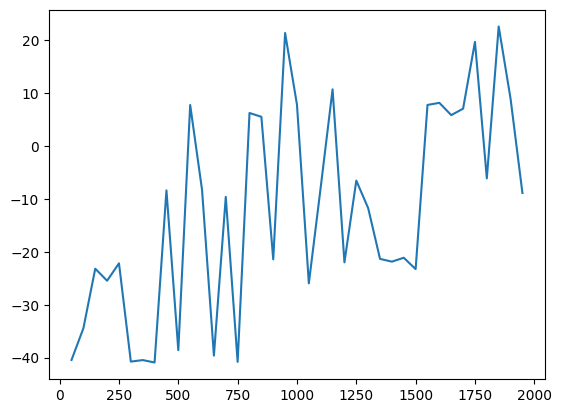

In [15]:
performance_ep = []
performance = []

#env.background_send_challenge(max_s.username)
#print("Battle Start")
for episode in range(num_episodes):
# display the performance
    #env.background_send_challenge(max_s.username)

    if (episode % measure_step == 0) and episode >= min_episodes:
        performance_ep.append(episode)
        performance.append(evaluate(Q_1, env, measure_repeats))
        print("Episode: ", episode)
        print("rewards: ", performance[-1])
        #print("lr: ", scheduler1.get_lr()[0])
        print("eps: ", eps)

    state1, info1 = env.reset()
    #state1, reward1, done1, _, _ = env.step(1)

    memory1.state.append(state1)

    done1 = False
    i = 0
    while not done1:
        i += 1
        action1 = select_action(Q_2, env, state1, eps)
        state1, reward1, done1, truncated, _ = env.step(action1) #Truncated?

        if i > horizon:
            done1 = True

        # save state, action, reward sequence
        memory1.update(state1, action1, reward1, done1)

    if episode >= min_episodes and episode % update_step == 0:
        for _ in range(50):
            train(batch_size, Q_1, Q_2, optimizer1, memory1, lr_gamma)

        # transfer new parameter from Q_1 to Q_2
        update_parameters(Q_1, Q_2)

    # update learning rate and eps
    #scheduler1.step()
    #state1, info1 = env.reset()
    eps = max(eps*eps_decay, eps_min)


plt.plot(np.array(performance_ep), np.array(performance))

What do these results mean? Well, it's not fantastic, the bot is unable to consistently win against a very formulaic player and is already converging in its epsilon value so it's not learning anything new.

# WHAT TO WORK ON
1. Redo the rewards
2. Rewrite some of Barry's configurations, as the template from Poke-env is causing it to make some moves incorrectly
3. Having the bots battle against each other to learn


# Lab for Manual Testing
Don't open this it's where I have random lines of code for debugging 

In [ ]:
print("selecting action")
action = select_action(Q_2, env_stall, state, eps)
print(f'action {action} selected')
#state, reward, done, truncated, _ = env_stall.step(action) #Truncated?

In [ ]:
print(env.current_battle)
print(env.agent.current_battle)
#print(env.agent._challenge_task)
await env._stop_challenge_loop()
env.background_send_challenge(max_s.username)

In [ ]:
print(env_stall.agent.current_battle == env_stall.current_battle)

In [ ]:
print(env_stall.current_battle)

In [ ]:
env_stall.reset_env(opponent='Espeox')

In [ ]:
env_stall.step(-1)

In [ ]:
env_stall.reset()